---
title: OSM - cityseer
date-format: long
date-modified: last-modified
lang: en
language:
  title-block-modified: "Last update"
---

See the accompanying discussion in the [guide](https://cityseer.benchmarkurbanism.com/guide).


Install and update `cityseer` if necessary.


In [1]:
# !pip install --upgrade cityseer
# !pip install osmnx

## Setup

If you're prepared to get your hands dirty, it is possible to directly query the [OSM API](https://wiki.openstreetmap.org/wiki/API) and to then use this data to create a `cityseer` graph. This can be preferred in situations where you want detailed control over the structure of the OSM API query. However, if you prefer, `OSM` data can also be retrieved with [`OSMnx`](https://osmnx.readthedocs.io) and then converted into a `cityseer` compatible `networkX` graph.

The following example makes use of data for London Soho.


In [2]:
import osmnx as ox
from shapely import geometry
import utm

from cityseer.tools import graphs, plot, io

# centrepoint
lng, lat = -0.13396079424572427, 51.51371088849723

# select extents for plotting
easting, northing = utm.from_latlon(lat, lng)[:2]
buffer_dist = 1250
buffer_poly = geometry.Point(easting, northing).buffer(1000)
min_x, min_y, max_x, max_y = buffer_poly.bounds


# reusable plot function
def simple_plot(_G):
    # plot using the selected extents
    plot.plot_nx(
        _G,
        labels=False,
        plot_geoms=True,
        node_size=4,
        edge_width=1,
        x_lim=(min_x, max_x),
        y_lim=(min_y, max_y),
        figsize=(6, 6),
        dpi=150,
    )


# Let's use OSMnx to fetch an OSM graph
# We'll use the same raw network for both workflows (hence simplify=False)
multi_di_graph_raw = ox.graph_from_point((lat, lng), dist=buffer_dist, simplify=False)

D:\Anaconda3\envs\Accessibility\Lib\site-packages\osmnx\graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


## Workflow 1

One option is to both download and simplify the data in `OSMnx` and to then convert the graph from `OSMnx` to `cityseer` (per the `io.nx_from_osm_nx` method).


Converting1...


INFO:cityseer.tools.io:Converting OSMnx MultiDiGraph to cityseer MultiGraph.


Converting2...


100%|███████████████████████████████████████████████████████████████████████████| 7090/7090 [00:00<00:00, 10117.89it/s]
INFO:cityseer.tools.plot:Preparing graph nodes
INFO:cityseer.tools.plot:Preparing graph edges
100%|███████████████████████████████████████████████████████████████████████████| 4112/4112 [00:00<00:00, 14883.25it/s]


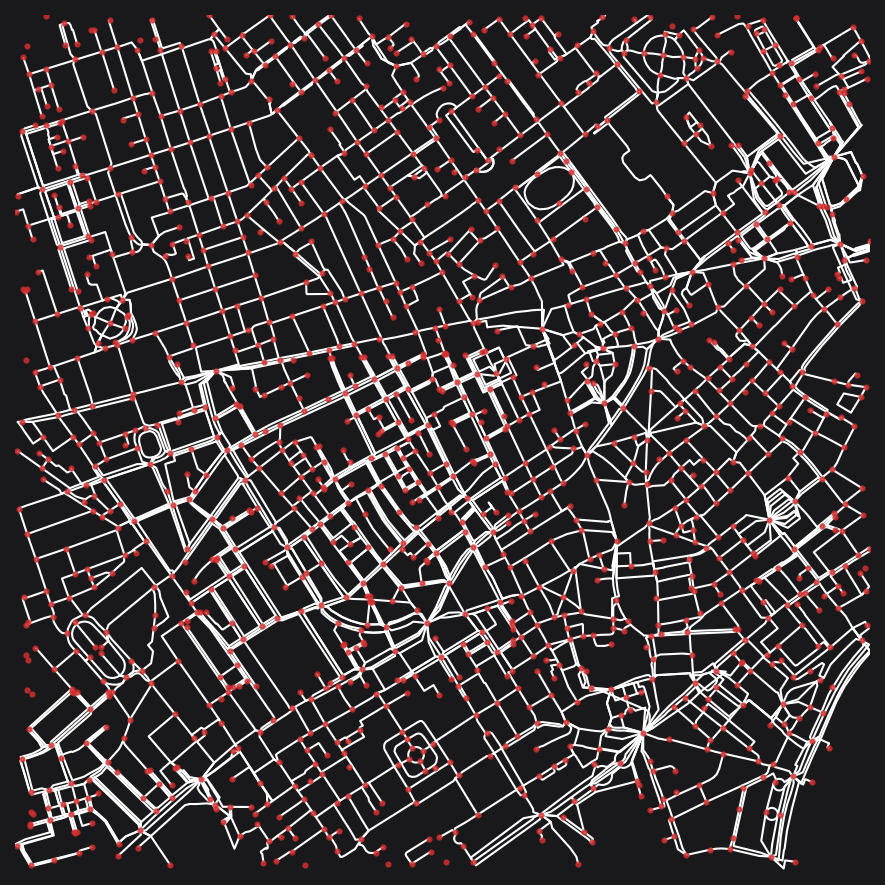

In [3]:
# Workflow 1: Using OSMnx to prepare the graph
# ============================================
# explicit simplification and consolidation via OSMnx
multi_di_graph_utm = ox.project_graph(multi_di_graph_raw)
multi_di_graph_simpl = ox.simplify_graph(multi_di_graph_utm)
print('Converting1...')
multi_di_graph_cons = ox.consolidate_intersections(
    multi_di_graph_simpl, tolerance=10, dead_ends=True
)
print('Converting2...')
# let's use the same plotting function for both scenarios to aid visual comparisons
multi_graph_cons = io.nx_from_osm_nx(multi_di_graph_cons, tolerance=50)
simple_plot(multi_graph_cons)

## Workflow 2

Another option is to immediately convert the `osmnx` graph to `cityseer` before downstream processing. This is preferable because it is then easier for `cityseer` to retain the integrity of the roadway geometries while enforcing node coordinate validation for intersections.


In [4]:
# WORKFLOW 2: Using cityseer to manually clean an OSMnx graph
# ===========================================================
G_raw = io.nx_from_osm_nx(multi_di_graph_raw)

INFO:cityseer.tools.io:Converting OSMnx MultiDiGraph to cityseer MultiGraph.
100%|██████████████████████████████████████████████████████████████████████████| 38251/38251 [00:03<00:00, 9767.43it/s]


In [5]:
G = io.nx_wgs_to_utm(G_raw)
G = graphs.nx_simple_geoms(G)
G = graphs.nx_remove_filler_nodes(G)
G = graphs.nx_remove_dangling_nodes(G)

INFO:cityseer.tools.io:Converting networkX graph from EPSG code 4326 to EPSG code 32630.
INFO:cityseer.tools.io:Processing node x, y coordinates.
100%|████████████████████████████████████████████████████████████████████████| 18873/18873 [00:00<00:00, 551212.66it/s]
INFO:cityseer.tools.io:Processing edge geom coordinates, if present.
100%|█████████████████████████████████████████████████████████████████████████| 22023/22023 [00:01<00:00, 13800.31it/s]
INFO:cityseer.tools.graphs:Generating interpolated edge geometries.
100%|████████████████████████████████████████████████████████████████████████| 22023/22023 [00:00<00:00, 112839.44it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|█████████████████████████████████████████████████████████████████████████| 18873/18873 [00:01<00:00, 12059.49it/s]
INFO:cityseer.tools.graphs:Removing dangling nodes.
100%|██████████████████████████████████████████████████████████████████████████| 6806/6806 [00:00<00:00, 379536.16it/s]


INFO:cityseer.tools.util:Creating nodes STR tree
100%|██████████████████████████████████████████████████████████████████████████| 6253/6253 [00:00<00:00, 129028.52it/s]
INFO:cityseer.tools.graphs:Consolidating nodes.
100%|████████████████████████████████████████████████████████████████████████████| 6253/6253 [00:02<00:00, 2976.35it/s]
INFO:cityseer.tools.graphs:Merging parallel edges within buffer of 25.
100%|███████████████████████████████████████████████████████████████████████████| 5275/5275 [00:00<00:00, 10348.55it/s]
INFO:cityseer.tools.util:Creating edges STR tree.
100%|██████████████████████████████████████████████████████████████████████████| 4388/4388 [00:00<00:00, 602047.95it/s]
INFO:cityseer.tools.graphs:Splitting opposing edges.
100%|████████████████████████████████████████████████████████████████████████████| 2783/2783 [00:00<00:00, 3336.42it/s]
INFO:cityseer.tools.graphs:Squashing opposing nodes
INFO:cityseer.tools.graphs:Merging parallel edges within buffer of 25.
100%|█

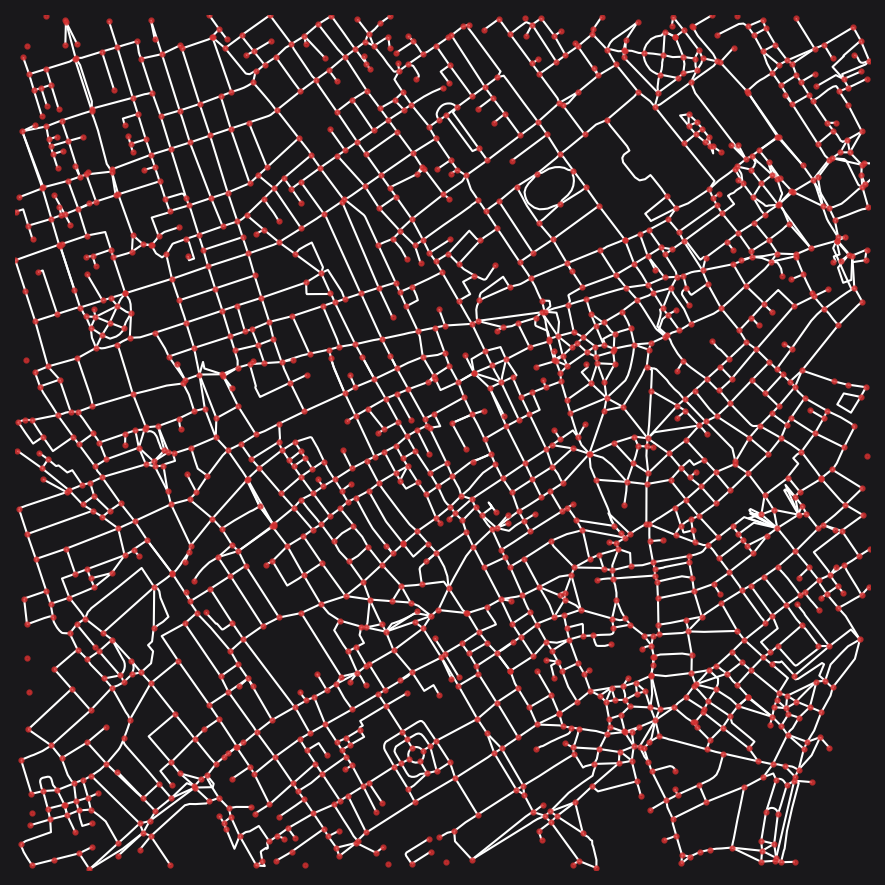

In [6]:
G1 = graphs.nx_consolidate_nodes(G, buffer_dist=12, crawl=True)
G2 = graphs.nx_split_opposing_geoms(G1, buffer_dist=15)
G3 = graphs.nx_consolidate_nodes(G2, buffer_dist=15, neighbour_policy="indirect")
G4 = graphs.nx_remove_filler_nodes(G3)
G5 = graphs.nx_iron_edges(G4)
simple_plot(G5)

## Workflow 3

A further option is to simply download the OSM graph directly from within `cityseer`. The following uses a default OSM query, however, the [OSM Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL) can be used to roll-your-own. See documentation for more information.


INFO:cityseer.tools.io:Converting networkX graph from EPSG code 4326 to EPSG code 32630.
INFO:cityseer.tools.io:Processing node x, y coordinates.
100%|████████████████████████████████████████████████████████████████████████| 13187/13187 [00:00<00:00, 596183.06it/s]
INFO:cityseer.tools.io:Processing edge geom coordinates, if present.
100%|████████████████████████████████████████████████████████████████████████| 14501/14501 [00:00<00:00, 802491.09it/s]
INFO:cityseer.tools.graphs:Generating interpolated edge geometries.
100%|█████████████████████████████████████████████████████████████████████████| 14501/14501 [00:00<00:00, 90762.53it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|█████████████████████████████████████████████████████████████████████████| 13187/13187 [00:01<00:00, 12564.14it/s]
INFO:cityseer.tools.graphs:Removing dangling nodes.
100%|██████████████████████████████████████████████████████████████████████████| 4682/4682 [00:00<00:00, 326919.56it/s]
INFO:cityseer.t

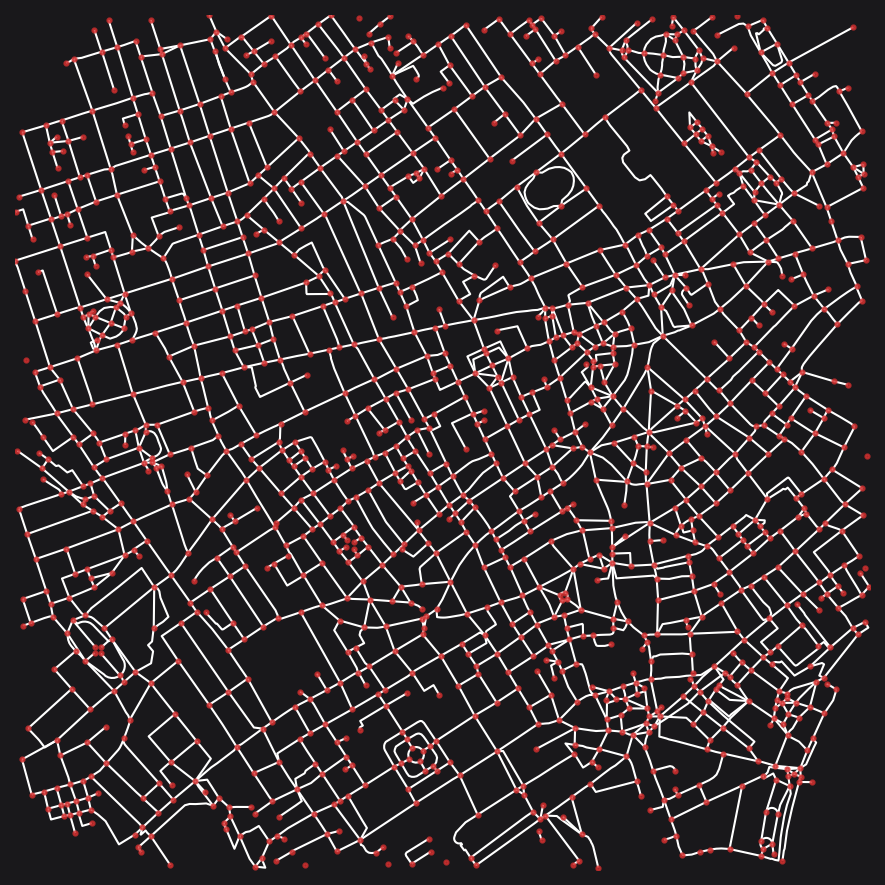

In [7]:
# WORKFLOW 3: Using cityseer to download and automatically simplify the graph
# ===========================================================================
poly_wgs, _ = io.buffered_point_poly(lng, lat, buffer_dist)
G_utm = io.osm_graph_from_poly(poly_wgs, simplify=True)
simple_plot(G_utm)

In [8]:
from cityseer.tools import graphs

# 分解进行更高分辨率的分析
G_decomp = graphs.nx_decompose(G_utm, 25)

INFO:cityseer.tools.graphs:Decomposing graph to maximum edge lengths of 25.
100%|████████████████████████████████████████████████████████████████████████████| 2763/2763 [00:00<00:00, 3199.73it/s]


In [9]:
nodes_gdf, _edges_gdf, network_structure = io.network_structure_from_nx(
    G_decomp, crs=32629
)

INFO:cityseer.tools.io:Preparing node and edge arrays from networkX graph.
100%|████████████████████████████████████████████████████████████████████████████| 6789/6789 [00:00<00:00, 9314.45it/s]


In [10]:
nodes_gdf

,ns_node_idx,x,y,live,weight,geom
108280,0,698596.635832,5.709391e+06,True,1,POINT (698596.636 5709390.827)
25258022,1,697705.801159,5.710145e+06,True,1,POINT (697705.801 5710145.181)
108271,2,698156.365097,5.709890e+06,True,1,POINT (698156.365 5709890.051)
109587,3,697752.413535,5.709988e+06,True,1,POINT (697752.414 5709987.854)
25257302,4,697877.703671,5.710107e+06,True,1,POINT (697877.704 5710107.250)
...,...,...,...,...,...,...
11101|29871±0±11101|29836,6784,699650.208528,5.711761e+06,True,1,POINT (699650.209 5711760.721)
11101|29871±1±11101|29836,6785,699654.849055,5.711740e+06,True,1,POINT (699654.849 5711739.880)
11101|29871±2±11101|29836,6786,699636.565460,5.711731e+06,True,1,POINT (699636.565 5711730.603)
11101|29871±3±11101|29836,6787,699620.798456,5.711745e+06,True,1,POINT (699620.798 5711745.375)


In [11]:
_edges_gdf

,ns_edge_idx,start_ns_node_idx,end_ns_node_idx,edge_idx,nx_start_node_key,nx_end_node_key,length,angle_sum,imp_factor,in_bearing,out_bearing,total_bearing,geom
108280-108280±0±3783410372,0,0,1849,0,108280,108280±0±3783410372,23.416965,31.973275,1,170.396851,138.423577,156.549347,"LINESTRING (698596.636 5709390.827, 698593.215..."
25258022-25258022±0±2356521713,1,1,1859,0,25258022,25258022±0±2356521713,24.965561,0.000000,1,17.509557,17.509557,17.509557,"LINESTRING (697705.801 5710145.181, 697729.610..."
108271-292903852,2,2,20,0,108271,292903852,13.544576,0.000000,1,120.911240,120.911240,120.911240,"LINESTRING (698156.365 5709890.051, 698149.407..."
108271-108271±0±260278456,3,2,1862,0,108271,108271±0±260278456,23.945895,0.000000,1,-109.118796,-109.118796,-109.118796,"LINESTRING (698156.365 5709890.051, 698148.522..."
108271-108271±0±260278453,4,2,1873,0,108271,108271±0±260278453,23.331524,0.000000,1,-52.577397,-52.577397,-52.577397,"LINESTRING (698156.365 5709890.051, 698170.543..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11101|29871±2±11101|29836-11101|29871±3±11101|29836,15401,6786,6787,0,11101|29871±2±11101|29836,11101|29871±3±11101|29836,21.874370,32.612596,1,166.832119,134.219522,136.866997,"LINESTRING (699636.565 5711730.603, 699634.762..."
11101|29871±3±11101|29836-11101|29865±11767|29836,15402,6787,1847,0,11101|29871±3±11101|29836,11101|29865±11767|29836,21.874370,0.000000,1,134.219522,134.219522,134.219522,"LINESTRING (699620.798 5711745.375, 699605.543..."
11101|29871±3±11101|29836-11101|29871±2±11101|29836,15403,6787,6786,0,11101|29871±3±11101|29836,11101|29871±2±11101|29836,21.874370,32.612596,1,-45.780478,-13.167881,-43.133003,"LINESTRING (699636.565 5711730.603, 699634.762..."
11101|29871±0±11101|29836§v2-11101|29871±11101|29871,15404,6788,1846,0,11101|29871±0±11101|29836§v2,11101|29871±11101|29871,21.719263,0.000000,1,28.284240,28.284240,28.284240,"LINESTRING (699643.795 5711781.634, 699624.669..."


In [12]:
from cityseer.tools import graphs, io

# download from OSM
lng, lat = -0.13396079424572427, 51.51371088849723
buffer = 5000
plot_buffer = 3500
# creates a WGS shapely polygon
poly_wgs, _ = io.buffered_point_poly(lng, lat, buffer)
poly_utm, _ = io.buffered_point_poly(lng, lat, buffer, projected=True)
plot_bbox = poly_utm.centroid.buffer(plot_buffer).bounds

In [13]:
plot_bbox

(695361.291295234, 5707348.649471334, 702361.291295234, 5714348.649471334)